### Load required libraries

In [1]:
## basc libraries
from __future__ import division
import os
from glob import glob

import urllib, cStringIO

## pymongo
import pymongo as pm

## plotting libraries
import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

## basic
import numpy as np
import pandas as pd
import json
import re

## for images
from PIL import Image
import base64

## scipy stats
import scipy.stats as stats
from scipy.spatial import distance
from scipy.stats import norm
import scipy.stats as stats

## sklearn
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

## under/over sampling libraries
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## custom functions
# import embedding as emb
# reload(emb)
# from embedding import *

## Define local custom functions

In [2]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def flatten(x):
    return [item for sublist in x for item in sublist]

def get_class_means(X, labels):    
    # load in and normalizes features first
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']    
#     F = np.load('/data5/bria/kiddraw_datasets/{}/features/FEATURES_{}_{}_Spatial_True.npy'.format(dataset,layers[layer_num],cohort))
#     M = pd.read_csv('/data5/bria/kiddraw_datasets/{}/features/METADATA_{}.csv'.format(dataset, cohort)) 
    F = np.load('../../../data/cnn-features/FEATURES_{}_{}_Spatial_True.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('../../../data/cnn-features/METADATA_{}.csv'.format(cohort)) 
    M = M[['label','age','session']]
    return F, M

def restrict_sesion(KF,KM,session_label):
    '''
    only look at drawings from certain session
    '''
    _KF = KF[KM['session'].str.contains(session_label),:]
    _KM = KM[KM['session'].str.contains(session_label)]
    return _KF, _KM

def get_class_means_bl(F, M,ordered_objs):  # just adapted to take in features and metadata directly; doesn't normalize  
    X = F;
    labels = M.label.values
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    for vi, v in enumerate(ordered_objs):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def get_class_means_bl_normalized(F, M,ordered_objs):  # just adapted to take in features and metadata directly; doesn't normalize  
    X = F;
    X = normalize(X);
    labels = M.label.values
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    for vi, v in enumerate(ordered_objs):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

### Load features from specific dataset and layer 

In [7]:
## CHOOSE LAYER IND FOR PLOTTING RDMS ETC
layer_ind = 6
# session_label = "run_v3"
# 
# dataset='rendered_111918'
## load in kid features
KF, KM = load_features('kid',layer_ind)
KF

array([[-0.5247637 ,  0.        , -0.05504415, ...,  2.93583941,
        -0.29798442, -0.01661097],
       [-0.13035074,  0.        , -0.05504415, ...,  3.51101995,
        -0.29798442, -0.01661097],
       [-0.5247637 ,  0.        , -0.05504415, ..., -0.44327027,
        -0.29798442, -0.01661097],
       ..., 
       [-0.5247637 ,  0.        , -0.05504415, ..., -0.44327027,
        -0.29798442, -0.01661097],
       [-0.5247637 ,  0.        , -0.05504415, ..., -0.44327027,
        -0.29798442, -0.01661097],
       [ 1.42087448,  0.        , -0.05504415, ..., -0.44327027,
        -0.29798442, -0.01661097]], dtype=float32)

## Get out labels and sorting indexes for the classes in this dataset

In [13]:
#  _labels = np.unique(KM.label.values)
# # ordered_objs_manual = ['house','couch','chair','airplane','bike','car','boat','train','bear','cat','rabbit','fish','bird','dog','frog','sheep','person','tree','bowl','phone','scissors','key','cup']
# ordered_objs_manual = ['house','couch','chair','airplane','bike','car','boat','train','bear','cat','rabbit','dog','sheep','bird','frog','fish','person','tree','bowl','phone','cup','scissors','key']


# ordered_objs = np.asarray(ordered_objs_manual) ## will be used repetitively throughout
# sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]

## save out for multiple uses
age_list = (2,3,4,5,6,7,8,9,10)

### If we wanted to using clustering instead of hand-sorted RDMs...

In [8]:
def flatten(x):
    return [item for sublist in x for item in sublist]

_labels = np.unique(KM.label.values)
means = get_class_means(KF, KM.label.values)
af = AffinityPropagation(damping=.5).fit(means)
labels = af.labels_
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

ordered_objs = []
print('Clusters')
for k in range(n_clusters_):
    class_members = labels == k
    print _labels[class_members]
    ordered_objs.append(list(_labels[class_members]))
    
ordered_objs = np.array(flatten(ordered_objs))

# define standard order to be used for RDM's across layers
standard_order = ordered_objs

## index for sorting the alphabetical list of labels INTO the order specified by ordered_objs (clustered)
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]
ordered_objs

Clusters
['TV' 'bed' 'book' 'chair' 'couch' 'piano']
['apple' 'boat' 'bottle' 'bowl' 'cup' 'hat' 'ice cream' 'lamp' 'mushroom'
 'phone']
['airplane' 'bear' 'bee' 'bike' 'bird' 'cactus' 'camel' 'car' 'cat' 'cow'
 'dog' 'elephant' 'fish' 'frog' 'hand' 'horse' 'key' 'octopus' 'person'
 'rabbit' 'scissors' 'sheep' 'snail' 'spider' 'tiger' 'train' 'tree'
 'watch' 'whale']
['clock' 'face']
['house']


array(['TV', 'bed', 'book', 'chair', 'couch', 'piano', 'apple', 'boat',
       'bottle', 'bowl', 'cup', 'hat', 'ice cream', 'lamp', 'mushroom',
       'phone', 'airplane', 'bear', 'bee', 'bike', 'bird', 'cactus',
       'camel', 'car', 'cat', 'cow', 'dog', 'elephant', 'fish', 'frog',
       'hand', 'horse', 'key', 'octopus', 'person', 'rabbit', 'scissors',
       'sheep', 'snail', 'spider', 'tiger', 'train', 'tree', 'watch',
       'whale', 'clock', 'face', 'house'],
      dtype='|S9')

### If we want to downsample dataset so balanced across age / category / their combination

In [9]:
## do same random under sampling we did for classification (set random state to same value)
# rus = RandomUnderSampler(random_state=0)
# KM['combined'] = KM['label'] + KM['age'].map(str)

# KF_downsampled, class_labels_downsampled = rus.fit_resample(KF, KM['combined'])
# new_samples_ind = rus.sample_indices_
# KM_downsampled = KM.loc[new_samples_ind]
# KM_downsampled = KM_downsampled.reset_index(drop=True)

# # ## reassign variable names
# KM = KM_downsampled
# KF = KF_downsampled

# ## restrict to classifcation outputs from cdm_run_v3 to match with mongodb meta; 
# ## we are actually missing 10 drawings from classification 
# ##(likely lost server conncetion) so have 10 more here...ugh
# KF, KM = restrict_sesion(KF,KM,session_label)
# KM = KM.reset_index(drop=True)

## Step 1. Descriptives of how many drawings / features

In [10]:
## print some variables
print 'Number of unique kids who contributed drawings = {}'.format(np.size(np.unique(KM['session'].values)))
print 'Number of features for {} images in layer {} = {}'.format(np.shape(KF)[0], layer_ind, np.shape(KF)[1])
feature_sketch_count = np.shape(KF)[0]

# excluded_drawing_number = png_sketch_count - feature_sketch_count
# print 'Number of excluded drawings = {}'.format(excluded_drawing_number)

Number of unique kids who contributed drawings = 8084
Number of features for 37770 images in layer 6 = 4096


### How many drawings do we have in each age group?

In [11]:
for age in range(2,11):
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    print 'We have {} {}-year olds who contributed {} drawings'.format(np.shape(np.unique(KM_subset['session']))[0],age, np.shape(KM_subset)[0])

We have 1231 2-year olds who contributed 3651 drawings
We have 1402 3-year olds who contributed 5342 drawings
We have 1451 4-year olds who contributed 6559 drawings
We have 1189 5-year olds who contributed 6411 drawings
We have 878 6-year olds who contributed 4990 drawings
We have 660 7-year olds who contributed 3817 drawings
We have 478 8-year olds who contributed 2570 drawings
We have 309 9-year olds who contributed 1800 drawings
We have 486 10-year olds who contributed 2630 drawings


#### How many kids did we exclude for interference in cdm_run_v4?

In [16]:
## use pymongo for database
import pymongo as pm

auth = pd.read_csv('../auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
cdm_run_v4 = db['cdm_run_v4']
cdm_run_v3 = db['cdm_run_v3']


all_surveys = cdm_run_v4.find({'$and': [{'dataType':'survey'},{'age':{"$ne": 'adult'}}]})
kid_drew = cdm_run_v4.find({'$and': [{'dataType':'survey'},{'child_drew':True},{'age':{"$ne": 'adult'}}]})
other_drew = cdm_run_v4.find({'$and': [{'dataType':'survey'},{'other_drew':True},{'age':{"$ne": 'adult'}}]})
parent_drew= cdm_run_v4.find({'$and': [{'dataType':'survey'},{'parent_drew':True},{'age':{"$ne": 'adult'}}]})

In [17]:
num_sessions = cdm_run_v4.find({'$and': [{'dataType':'finalImage'},{'age':{"$ne": 'adult'}}]}).distinct('sessionId')

In [29]:
not_empty_count = other_drew.count() + parent_drew.count() + kid_drew.count()
interference_count = other_drew.count() + parent_drew.count()

interference_pc = interference_count / all_surveys.count()
interference_pc = interference_pc * 100


In [30]:
print'Out of {} sessions, {} filled out the survey, and {} reported interference, {} of participants'.format(all_surveys.count(), not_empty_count, interference_count,interference_pc)

Out of 2685 sessions, 700 filled out the survey, and 156 reported interference, 5.81005586592 of participants


"Out of 2685 sessions, 700 filled out the survey, and 156 reported interference, 5.81005586592 of participants"
Copied output from cogsci submission -- could change since more kids drew!

# Examine changes in variability

### Measure overall feature activation, image variability in feature space, and distances between category centers

In [14]:
# image variability -- diff numbers of images per age group, just save out avg/std
feature_activation_by_age = np.zeros([9,np.shape(KF)[1]])
avg_feat_variability_by_age = np.zeros(9)
sem_feat_variability_by_age = np.zeros(9)

for i,age in enumerate(age_list):
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    
    # how much are features activated overall, regardless of category
    feature_activation_by_age[i,] = np.mean(KF_subset, axis=0) ## by features
    
    # how much do images vary (on average) in their features by each age
    avg_feat_variability_by_age[i] = np.mean(np.std(KF_subset,axis = 1))
    
    # get variability across these stds -- standard deviation of standard deviation, divide by sqrt(num_images)
    sem_feat_variability_by_age[i] = np.std(np.std(KF_subset,axis = 1))/(np.sqrt(np.shape(KF_subset)[0]))


In [15]:
avg_feat_variability_by_age

array([ 0.86513054,  0.86192155,  0.85347086,  0.87364173,  0.86567634,
        0.88872677,  0.89939296,  0.89411455,  0.93700111])

In [16]:
# write out features to dataframe for use in r possibly ? 
# features_df = pd.DataFrame(KF)
# out = pd.concat([KM,features_df],axis=1)
# out.to_csv('museumstation_subset_features.csv')

#### Plot average feature activation by age 

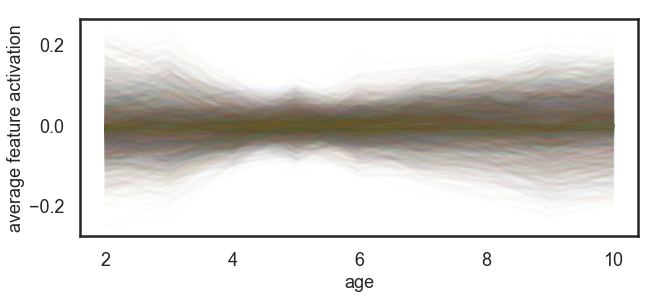

In [18]:
# Average feature activation at each age, where each point is an average of all feature activatinos (4096) 
fig = plt.figure(figsize=(10,4))
plt.plot(age_list, feature_activation_by_age, alpha=.01)
# plt.scatter(age_list, feature_activation_by_age)
# plt.errorbar(age_list,np.mean(feature_activation_by_age,1),yerr = np.std(feature_activation_by_age,1)/np.sqrt(4096))
plt.ylabel('average feature activation',fontsize = 18)
plt.xlabel('age', fontsize = 18)
plt.xticks(fontsize = 18); 
plt.yticks(fontsize = 18); 

# plt.savefig('./plots/FeatureActivationbyAge.png', bbox_inches="tight")

#### Plot average feature std by age 

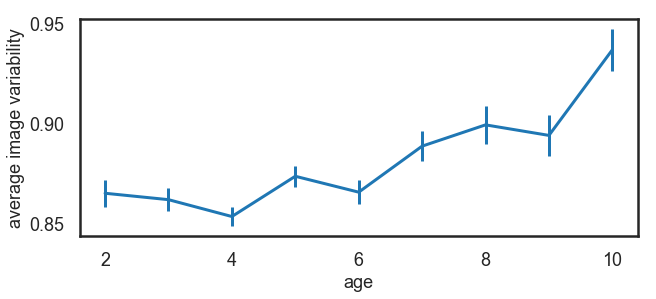

In [19]:
# Average variability in feature activation at each age, where each point is an average of standard deviations across 
# the feature dimensions (4096) for all images in an age group

fig = plt.figure(figsize=(10,4))
plt.errorbar(age_list,avg_feat_variability_by_age,yerr = sem_feat_variability_by_age)
plt.ylabel('average image variability',fontsize = 18)
plt.xlabel('age', fontsize = 18)
plt.xticks(fontsize = 18); 
plt.yticks(fontsize = 18); 

plt.savefig('./plots/ImageVariabilitybyAge.png', bbox_inches="tight")

### How does the overall distnace to the center of the space change with age?

In [20]:
## jacknife resampling over class
def get_overall_distances(KF, KM, ordered_objs):
    # get class means and calculate distance between them
    class_means = get_class_means_bl(KF_subset,KM_subset, ordered_objs)
    age_distances = distance.pdist(class_means,'euclidean')
#     grand_mean = np.mean(class_means,0)
    grand_mean = np.mean(KF_subset,0)
    # open up variances
    overall_dist = np.zeros([np.shape(ordered_objs)[0]])
    overall_dist_sq = np.zeros([np.shape(ordered_objs)[0]])
    for c,l in enumerate(ordered_objs):
        overall_dist[c]=distance.euclidean(grand_mean,class_means[c,])
        overall_dist_sq[c]=overall_dist[c]**2
    return(overall_dist_sq)

def get_grand_mean_dist(KF, KM, ordered_objs,grand_mean):
    # get class means and calculate distance between them
    class_means = get_class_means_bl(KF_subset,KM_subset, ordered_objs)
    age_distances = distance.pdist(class_means,'euclidean')
    # open up variances
    overall_dist = np.zeros([np.shape(ordered_objs)[0]])
    overall_dist_sq = np.zeros([np.shape(ordered_objs)[0]])
    for c,l in enumerate(ordered_objs):
        overall_dist[c]=distance.euclidean(grand_mean,class_means[c,])
        overall_dist_sq[c]=overall_dist[c]**2
    return(overall_dist_sq)

distances_jacknifed_grand_mean = np.zeros([np.shape(age_list)[0], np.shape(ordered_objs)[0]-1,np.shape(ordered_objs)[0]])
distances_jacknifed_age_means = np.zeros([np.shape(age_list)[0], np.shape(ordered_objs)[0]-1,np.shape(ordered_objs)[0]])

age_list = (2,3,4,5,6,7,8,9,10)

#
class_means = get_class_means_bl(KF,KM, ordered_objs)
grand_mean_all_data = np.mean(class_means,0)

for agei,age in enumerate(age_list):
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    
    for li,l in enumerate(ordered_objs):
        ordered_objs_loo = np.delete(ordered_objs,li)
        distances_jacknifed_grand_mean[agei,:,li]=get_grand_mean_dist(KF_subset, KM_subset, ordered_objs_loo,grand_mean_all_data)
        distances_jacknifed_age_means[agei,:,li]=get_overall_distances(KF_subset, KM_subset, ordered_objs_loo)
        


NameError: name 'jacknifed_means' is not defined

### Category centers become farther away from grand mean of feature space across age

In [94]:
iter_avg = np.mean(distances_jacknifed_age_means,axis=1)  ## average across iterations first since roows aren't compatible

# columns are categories that are left out from the mean, rows are ages
jacknifed_means = pd.DataFrame(iter_avg,columns = ordered_objs)
jacknifed_means.to_csv('csv_data_for_cogsci/distances_jacknifed_age_means_dec13.csv')

# out = pd.concat([ordered_objs,jacknifed_means],axis=1)
# Frame=pd.DataFrame([jacknifed_means], )

# jacknifed_means.col_names(ordered_objs)
# out.to_csv('museumstation_subset_features.csv')

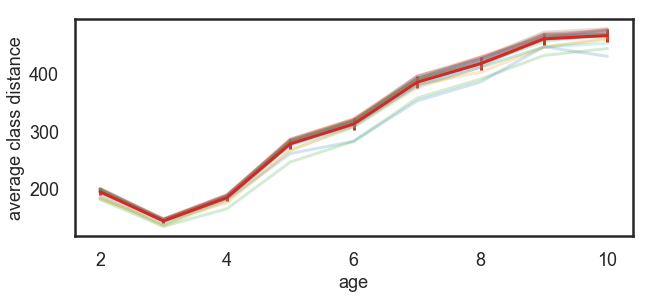

In [15]:
iter_avg = np.mean(distances_jacknifed_age_means,axis=1)  ## average across iterations first since roows aren't compatible
avg_distnace = np.mean(iter_avg,axis=1)
sem_distance = np.std(iter_avg,axis=1)

fig = plt.figure(figsize=(10,4))
plt.plot(age_list, iter_avg, alpha=.2)
plt.errorbar(age_list,avg_distnace, sem_distance)
plt.ylabel('average class distance',fontsize = 18)
plt.xlabel('age', fontsize = 18)
plt.xticks(fontsize = 18); 
plt.yticks(fontsize = 18); 

plt.savefig('./plots/AvgCategoryDistbyAge.png', bbox_inches="tight")

## How does category dispersion change with age?

In [96]:

class_distances=np.zeros([9,np.shape(ordered_objs)[0]])
class_distances_cosine=np.zeros([9,np.shape(ordered_objs)[0]])

def get_cosine_distance_to_center(F,M,this_label):    
    class_features = F[M.label.values==this_label]
    class_mean = class_features.mean(0); # mean ovver rows, i.e. images
    num_images = np.shape(class_features)[0] # number of images for this class in this set
    _dist = np.zeros(num_images)   
    for vi in range(num_images): 
        _dist[vi] = distance.cosine(class_features[vi],class_mean) ## get cosine distance to mean
    return (_dist) 

def get_category_disperson_euclidean(F,M,this_label):    
    class_features = F[M.label.values==this_label]
    class_mean = class_features.mean(0); # mean ovver rows, i.e. images
    num_images = np.shape(class_features)[0] # number of images for this class in this set
    _dist = np.zeros(num_images)
    _dist_sq = np.zeros(num_images)
    for vi in range(num_images): 
        _dist[vi] = distance.euclidean(class_features[vi],class_mean) ## get cosine distance to mean
        _dist_sq[vi]=_dist[vi]**2
    std = np.sqrt(np.sum(_dist_sq))   
    return (std) 


for i, age in enumerate(age_list):
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    
    ## for each class, age get distance to category center
    for l, this_label in enumerate(ordered_objs):
        these_distances = get_category_disperson_euclidean(KF_subset,KM_subset,this_label)
        cosine_distances = get_cosine_distance_to_center(KF_subset,KM_subset,this_label)
        class_distances[i,l]=these_distances
        class_distances_cosine[i,l]=np.median(cosine_distances,axis=0)


In [99]:
# columns are categories, rows are age
class_distances = pd.DataFrame(class_distances,columns = ordered_objs)
class_distances.to_csv('csv_data_for_cogsci/class_dispersion_by_age_dec13.csv')

### Does average euclidean distance to category centers decrease with age?


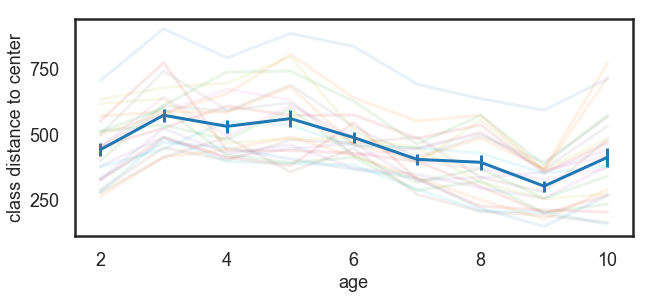

In [15]:
fig = plt.figure(figsize=(10,4))
plt.errorbar(age_list,np.mean(class_distances,axis=1), yerr=np.std(class_distances,axis=1)/np.sqrt(np.shape(ordered_objs)[0]))
plt.plot(age_list, class_distances, alpha=.1)
plt.ylabel('class distance to center',fontsize = 18)
plt.xlabel('age', fontsize = 18)
plt.xticks(fontsize = 18); 
plt.yticks(fontsize = 18); 

# plt.savefig('./plots/CategoryDispersionByAge_all_classes.png', bbox_inches="tight")

### Does average cosine distance to category centers decrease with age?


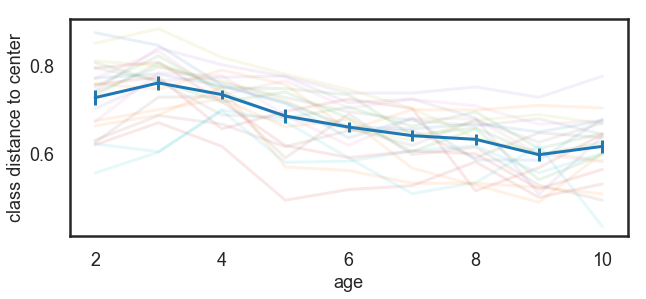

In [16]:
fig = plt.figure(figsize=(10,4))
plt.errorbar(age_list,np.mean(class_distances_cosine,axis=1), yerr=np.std(class_distances_cosine,axis=1)/np.sqrt(np.shape(ordered_objs)[0]))
plt.plot(age_list, class_distances_cosine, alpha=.1)
plt.ylabel('class distance to center',fontsize = 18)
plt.xlabel('age', fontsize = 18)
plt.xticks(fontsize = 18); 
plt.yticks(fontsize = 18); 

# plt.savefig('./plots/CategoryDispersionByAge_all_classes.png', bbox_inches="tight")

## Get RDM correlations across age

In [26]:
## Calculate RDMS for each age and correlation with olderst 
rdm_by_age = np.zeros([9,1128])

rdm_corr_by_age = np.zeros(8)

for age in range(10,1,-1):
    agei = age-2
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]

    class_means = get_class_means_bl(KF_subset, KM_subset, ordered_objs)
    this_rdm = distance.pdist(class_means,'cosine')
    
    if age==10:
        oldest_rdm = this_rdm
    else:
        rdm_by_age[agei,] = this_rdm
        out = stats.spearmanr(this_rdm,oldest_rdm)
        rdm_corr_by_age[agei] = out.correlation
        print 'RDM corr for age {} vs age 10 is {}'.format(age, rdm_corr_by_age[agei])

RDM corr for age 9 vs age 10 is 0.937314288196
RDM corr for age 8 vs age 10 is 0.938496364026
RDM corr for age 7 vs age 10 is 0.936481013403
RDM corr for age 6 vs age 10 is 0.926657939088
RDM corr for age 5 vs age 10 is 0.863103368397
RDM corr for age 4 vs age 10 is 0.822357524458
RDM corr for age 3 vs age 10 is 0.78230833781
RDM corr for age 2 vs age 10 is 0.8131759755


In [25]:
np.shape(this_rdm)

(1128,)

(array([ 0.75,  0.8 ,  0.85,  0.9 ,  0.95]),
 <a list of 5 Text yticklabel objects>)

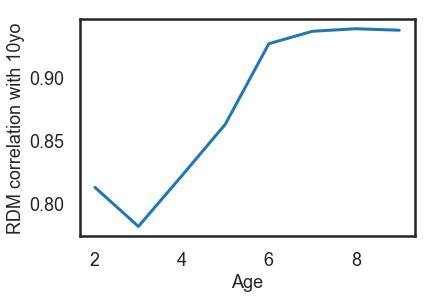

In [27]:
age_list_plot=(2,3,4,5,6,7,8,9)
plt.plot(age_list_plot, rdm_corr_by_age)
plt.ylabel('RDM correlation with 10yo',fontsize = 18)
plt.xlabel('Age', fontsize = 18)
plt.xticks(fontsize = 18); 
plt.yticks(fontsize = 18); 

## Get jacknifed estimates of variability around correlation

In [153]:
rdm_corr_by_age_jack = np.zeros([8,np.shape(ordered_objs)[0]])

for li,l in enumerate(ordered_objs):
    ordered_objs_loo = np.delete(ordered_objs,li)
    print 'leaving out {} from RDMs..'.format(l)

    for agei,age in enumerate(range(10,1,-1)): # go backwards so we get age10 first
        agei = agei - 1
        ind = KM.index[KM['age'] == age]
        KM_subset =  KM.loc[ind]
        KF_subset =  KF[ind.tolist()]
        
        class_means = get_class_means_bl_normalized(KF_subset, KM_subset, ordered_objs_loo)
        this_rdm = distance.pdist(class_means,'euclidean')
        
        if age==10:
            oldest_rdm = this_rdm
#             print 'Computed oldest RDM for this subset {}'.format(age)
        else:
            out = stats.spearmanr(this_rdm,oldest_rdm)
            rdm_corr_by_age_jack[agei,li] = out.correlation

leaving out house from RDMs..
leaving out couch from RDMs..
leaving out chair from RDMs..
leaving out airplane from RDMs..
leaving out bike from RDMs..
leaving out car from RDMs..
leaving out boat from RDMs..
leaving out train from RDMs..
leaving out bear from RDMs..
leaving out cat from RDMs..
leaving out rabbit from RDMs..
leaving out dog from RDMs..
leaving out sheep from RDMs..
leaving out bird from RDMs..
leaving out frog from RDMs..
leaving out fish from RDMs..
leaving out person from RDMs..
leaving out tree from RDMs..
leaving out bowl from RDMs..
leaving out phone from RDMs..
leaving out cup from RDMs..
leaving out scissors from RDMs..
leaving out key from RDMs..


#### Write out to CSV

In [139]:

rdm_corr_sem = np.std(rdm_corr_by_age_jack,1)/np.sqrt(23)
rdm_corr_avg = rdm_corr_by_age
rdm_corr_out = {'rdm_corr_avg': rdm_corr_avg, 'rdm_corr_sem': rdm_corr_sem}

# # columns are categories, rows are age
rdm_corr = pd.DataFrame(rdm_corr_out)
rdm_corr.to_csv('csv_data_for_cogsci/rdm_corr_by_age_dec13.csv')

### Calculate d-prime by age

In [29]:
# Gets "std" of each class (e.g., category) in a feature space
def get_class_std(F,M,this_label):    
    class_features = F[M.label.values==this_label]
    class_mean = class_features.mean(0); # mean ovver rows, i.e. images
    num_images = np.shape(class_features)[0] # number of images for this class in this set
    # open variables
    _dist = np.zeros(num_images)   
    _dist_sq = np.zeros(num_images) 
    # for each image, get distance to category mean and square it
    for vi in range(num_images): 
        _dist[vi] = distance.euclidean(class_features[vi],class_mean) ## get euclidean distance to mean
        _dist_sq[vi] = _dist[vi]**2 # square each distance
    dist_sum = sum(_dist_sq) / num_images; # sum these distances and divide by the number of IMAGES
    return np.sqrt(dist_sum) #  get square root to make it a std (RMSE)

# Use mean and std to compute a higher-dimensional d-prime matrix
def get_class_dprime(class_std, class_means,ordered_objs):
    d_prime = np.zeros((len(np.unique(ordered_objs)), len(np.unique(ordered_objs)))); # n-class x n-class matrix      
    for i, v in enumerate(ordered_objs): # go through each list of classes
        for i2, v2 in enumerate(ordered_objs): # and each pair of classes
            if i==i2: # if we're in the diagonal
                d_prime[i,i2] = 0; # give dummy value when looking at same category, 0 = the same category
            else:
                sd1=class_std[i]; sd2=class_std[i2]; # grab class variance for each pair of categories
                m1=class_means[i];  m2=class_means[i2]; # grab class means for each pair of categories
                num = distance.euclidean(m1,m2) # distance between two mean vectors
                denom = np.sqrt(.5*(sd1**2+sd2**2)); # calculate denominator 
                d=num/denom;
                d_prime[i,i2] = d;  # fill in matrix
    return d_prime;

def show_dprime(d_prime,ordered_objs,age):
#     sns.set_context('paper')
    fig = plt.figure(figsize=(80,80))
    plt.matshow(d_prime, vmin=0, vmax=.9) # maximum pairwise value in data is .87
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
#     plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False 
    plt.savefig('./plots/Dprime_{}_Layer_{}.pdf'.format(age, layer_ind), bbox_inches="tight")
    plt.savefig('./plots/Dprime_{}_Layer_{}.svg'.format(age, layer_ind), bbox_inches="tight")
    


### Get average without resampling

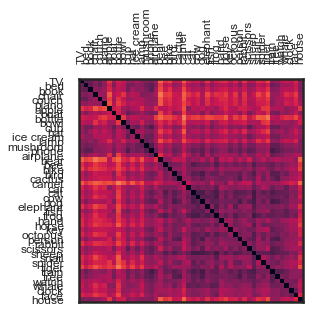

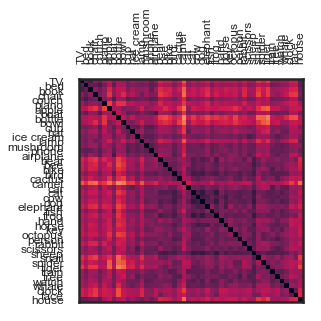

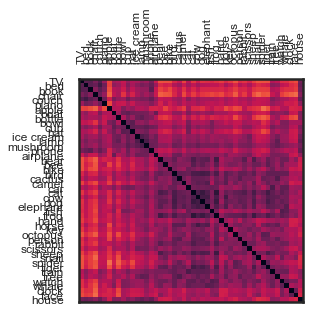

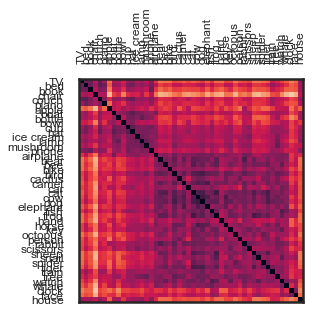

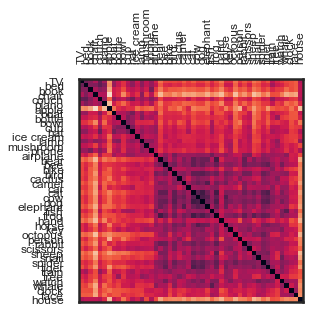

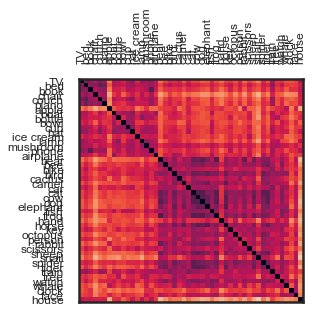

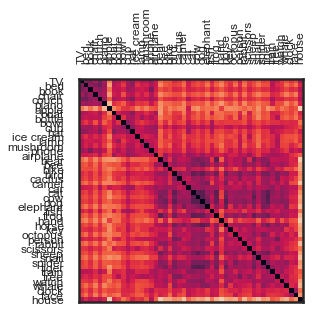

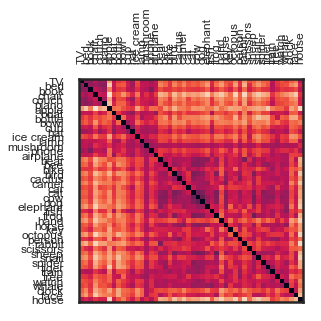

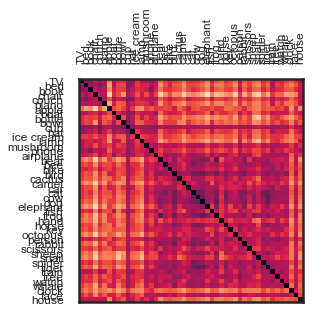

In [30]:
dim=46
class_list = np.asarray(np.unique(KM.label.values))
dprime_by_age = np.zeros([np.shape(class_list)[0], np.shape(class_list)[0], np.shape(range(2,11))[0]])
dprime_avg_by_age = np.zeros(np.shape(range(2,11)))

for agei,age in enumerate(range(2,11)):
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    class_means = np.zeros(np.shape(class_list)[0])
    class_std = np.zeros(np.shape(class_list)[0])  
    #
    class_means = get_class_means_bl(KF_subset, KM_subset, ordered_objs)
    for l, this_label in enumerate(ordered_objs): # goes through ordered list
        class_std[l] = get_class_std(KF_subset,KM_subset,this_label)
    dprime_this_age = get_class_dprime(class_std, class_means, ordered_objs)
    dprime_by_age[:,:,agei] = dprime_this_age
    show_dprime(dprime_this_age,ordered_objs,age)
#     print np.max(dprime_this_age)
    dprime_avg_by_age[agei] = np.mean(np.ravel(dprime_this_age[np.triu_indices(dim,k=1)]))

In [31]:
# matplotlib.rcParams.update({'font.size': 60})
params = {'xtick.labelsize': 12, 'ytick.labelsize': 12}
matplotlib.rcParams.update(params)

# show_dprime(dprime_this_age,ordered_objs,age)

### Now do jacknife resampling on class

In [33]:
dim=46
class_list = np.asarray(np.unique(KM.label.values))
dprime_by_age = np.zeros([np.shape(class_list)[0], np.shape(class_list)[0], np.shape(range(2,11))[0]])
dprime_avg_by_age_jack = np.zeros([np.shape(range(2,11))[0], np.shape(ordered_objs)[0]])

for agei,age in enumerate(range(2,11)):
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]

    print 'Jacknifing for age  {}..'.format(age)
    for li,l in enumerate(ordered_objs):
        ordered_objs_loo = np.delete(ordered_objs,li)
        dim = np.shape(ordered_objs_loo)[0]
#         print 'leaving out {} from RDM..'.format(l)

        class_means = np.zeros(np.shape(ordered_objs_loo)[0])
        class_std = np.zeros(np.shape(ordered_objs_loo)[0]) 
        class_means = get_class_means_bl(KF_subset, KM_subset, ordered_objs_loo)
        
        for l, this_label in enumerate(ordered_objs_loo): # goes through ordered list
            class_std[l] = get_class_std(KF_subset,KM_subset,this_label)
        dprime_this_age = get_class_dprime(class_std, class_means, ordered_objs_loo)
        
        dprime_avg_by_age_jack[agei,li] = np.mean(np.ravel(dprime_this_age[np.triu_indices(dim,k=1)]))

Jacknifing for age  2..
Jacknifing for age  3..
Jacknifing for age  4..
Jacknifing for age  5..
Jacknifing for age  6..
Jacknifing for age  7..
Jacknifing for age  8..
Jacknifing for age  9..
Jacknifing for age  10..


In [32]:
## Dprime SEM
dprime_sem = np.std(dprime_avg_by_age_jack,1)/np.sqrt(23)
dprime_out = {'dprime_avg': dprime_avg_by_age, 'dprime_sem': dprime_sem}

# # columns are categories, rows are age
dprime_out_df = pd.DataFrame(dprime_out)
dprime_out_df.to_csv('csv_data_for_cogsci/dprime_by_age_dec13.csv')

NameError: name 'dprime_avg_by_age_jack' is not defined

# How does class discriminability change with age?

In [39]:
def get_two_class_discrim(F,M,target_class,confusion_class):    
    target_class_features = F[M.label.values==target_class]
    target_class_mean = np.median(target_class_features, axis=0); # MEDIAN ovver rows, i.e. images
    num_target_images=np.shape(target_class_features)[0];
    
    conf_class_features = F[M.label.values==confusion_class]
    conf_class_mean = np.median(conf_class_features, axis=0); # MEDIAN ovver rows, i.e. images
    
    # open variables
    dist_target = np.zeros(num_target_images)   
    dist_conf = np.zeros(num_target_images) 
    discrim_target_conf = np.zeros(num_target_images)
    discrim_target_pc = np.zeros(num_target_images)
    # for each image, get distance to category mean and to distractor mean
    for vi in range(num_target_images): 
        dist_target[vi] = distance.euclidean(target_class_features[vi],target_class_mean) ## get euclidean distance to mean
        dist_conf[vi] = distance.euclidean(target_class_features[vi],conf_class_mean) ## get euclidean distance to conf mean
        discrim_target_conf[vi]=dist_conf[vi]-dist_target[vi] ## subtract -- higher values: more discrim
        if discrim_target_conf[vi]>0:
            discrim_target_pc[vi]=1
    two_class_discrim = np.mean(discrim_target_conf)
    two_class_pc = np.mean(discrim_target_pc)
    return(two_class_discrim,two_class_pc)

def show_confMatrix(confMatrix,ordered_objs,age):
    sns.set_context('paper')
    fig = plt.figure(figsize=(40,40))
#     plt.matshow(confMatrix, vmin=-2, vmax=20) # maximum pairwise value in data?
    plt.matshow(confMatrix) # maximum pairwise value in data?
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90,fontsize = 12);
    plt.yticks(range(len(ordered_objs)), ordered_objs,fontsize = 12); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False 
#     plt.savefig('./plots-dec5/TwoClassDiscrim_{}_Layer_{}.pdf'.format(age, layer_ind), bbox_inches="tight")

In [40]:
# np.shape(np.unique(confMatrix[np.where(~np.eye(confMatrix.shape[0],dtype=bool))]))

KeyboardInterrupt: 

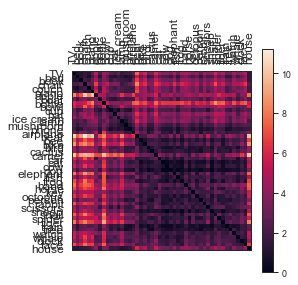

In [41]:
confMatrixbyAge = np.zeros([np.shape(ordered_objs)[0],np.shape(ordered_objs)[0],9])
for age in (2,3,4,5,6,7,8,9,10):
    agei=age-2
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    
    
    confMatrix = np.zeros([np.shape(ordered_objs)[0],np.shape(ordered_objs)[0]])
    confMatrix_PC = np.zeros([np.shape(ordered_objs)[0],np.shape(ordered_objs)[0]])
    for t, target_label in enumerate(ordered_objs):
        for c, conf_label in enumerate(ordered_objs):
            two_class_discrim, two_class_pc = get_two_class_discrim(KF_subset,KM_subset,target_label,conf_label)  
            
            confMatrix[t,c]=two_class_discrim
            confMatrix_PC[t,c]=two_class_pc

#     print np.mean(confMatrix_PC[np.where(~np.eye(confMatrix_PC.shape[0],dtype=bool))])
#     confMatrixbyAge[:,:,agei]=confMatrix
    show_confMatrix(confMatrix,ordered_objs,age)
#     show_confMatrix(confMatrix_PC,ordered_objs,age)


In [55]:
# import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 14})

def plot_and_save_RDM(M,F,age,dataset,ordered_objs, layer_ind):
    ordered_means = get_class_means_bl(F, M, ordered_objs)
    corrmat = np.corrcoef(ordered_means)
    sns.set_style('white')
    sns.set_context('paper')
    fig = plt.figure(figsize=(60,60))
    plt.matshow(1-corrmat, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90, fontsize=6);
    plt.yticks(range(len(ordered_objs)), ordered_objs,  fontsize=6); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    plt.gcf().subplots_adjust(left=0.5) 
    plt.savefig('./plots/RDM_{}_{}_Layer_{}.pdf'.format(age, dataset, layer_ind), bbox_inches="tight")

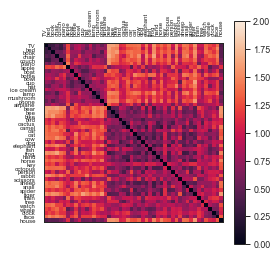

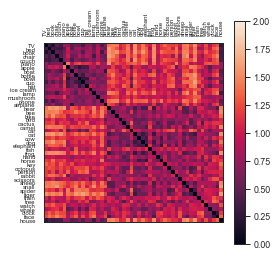

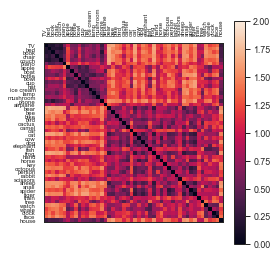

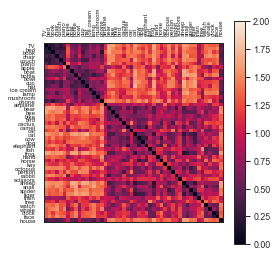

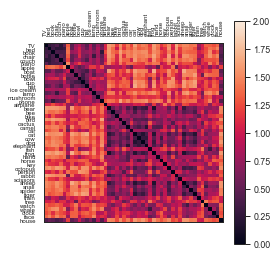

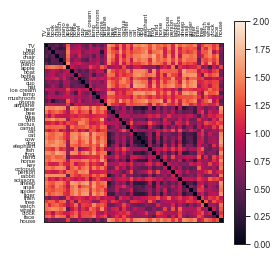

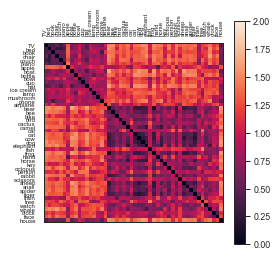

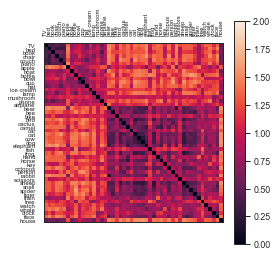

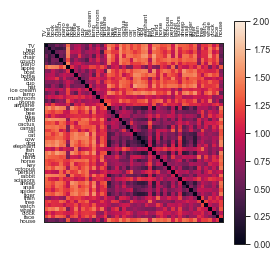

In [56]:
for age in (2,3,4,5,6,7,8,9,10):
    agei=age-2
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    
    plot_and_save_RDM(KM_subset, KF_subset,age,'sept_20_37K', ordered_objs, layer_ind)

### Look at multi-class MDS for each age using tSNE for dimensionality reduction -- eh, not convinced this is useful

In [522]:
## Import libaries
from sklearn.metrics import pairwise
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
seed = np.random.RandomState(seed=3)
from sklearn import manifold
from sklearn.manifold import TSNE

# https://distill.pub/2016/misread-tsne/ -- good resource


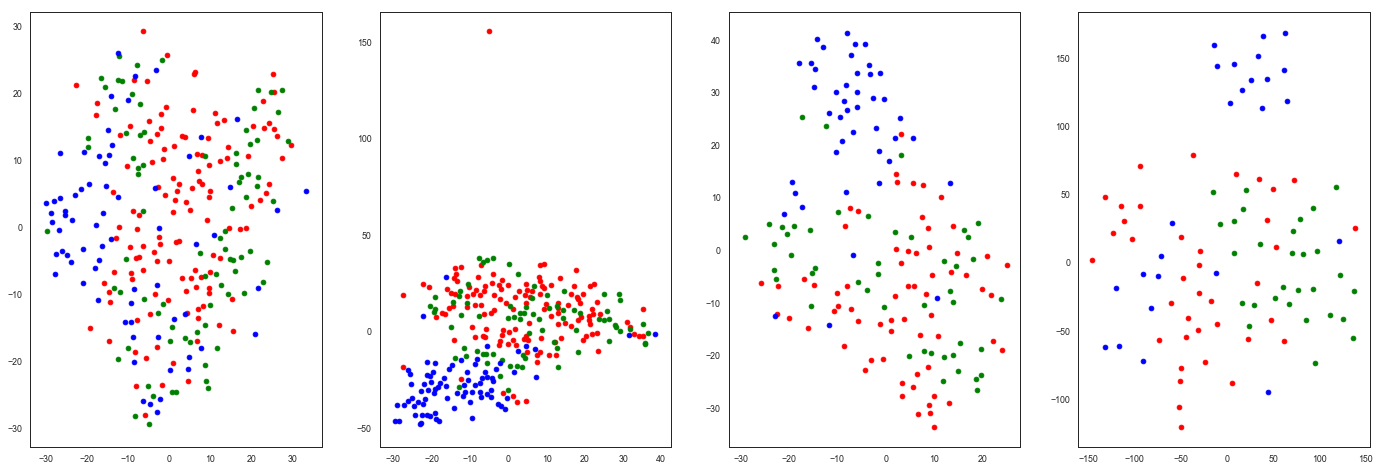

In [41]:
from sklearn import manifold
n_samples = 100 # roughly minimum we might have with two classes
n_components = 2
perplexity = 10 ## arbitrary value -- "(loosely) how to balance attention between local and global aspects of your data. 

# Cluster sizes in a t-SNE plot mean nothing
# The basic message is that distances between well-separated clusters in a t-SNE plot may mean nothing.

first_class='fish'
second_class='bird'
third_class='chair'

age_test = [3,5,7,9]
(fig, subplots) = plt.subplots(1,len(age_test), figsize=(24, 8))
for agei, age in enumerate(age_test):
    ## Subset to the age and classes of interest
    ind = KM.index[KM['age'] == age] & (KM.index[KM.label.values==first_class] | KM.index[KM.label.values==second_class] | KM.index[KM.label.values==third_class])
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    KM_subset = KM_subset.reset_index(drop=True)

    
    first_class_ind = [KM_subset['label']==first_class][0]
    second_class_ind = [KM_subset['label']==second_class][0]
    third_class_ind = [KM_subset['label']==third_class][0]

    tsne = manifold.TSNE(n_components=n_components, init='random',
                             random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(KF_subset)
    ax = subplots[agei]
    
    
    ax.scatter(Y[first_class_ind, 0], Y[first_class_ind, 1], c='r')
    ax.scatter(Y[second_class_ind, 0], Y[second_class_ind, 1], c='g')
    ax.scatter(Y[third_class_ind, 0], Y[third_class_ind, 1], c='b')


## Dendograms ?


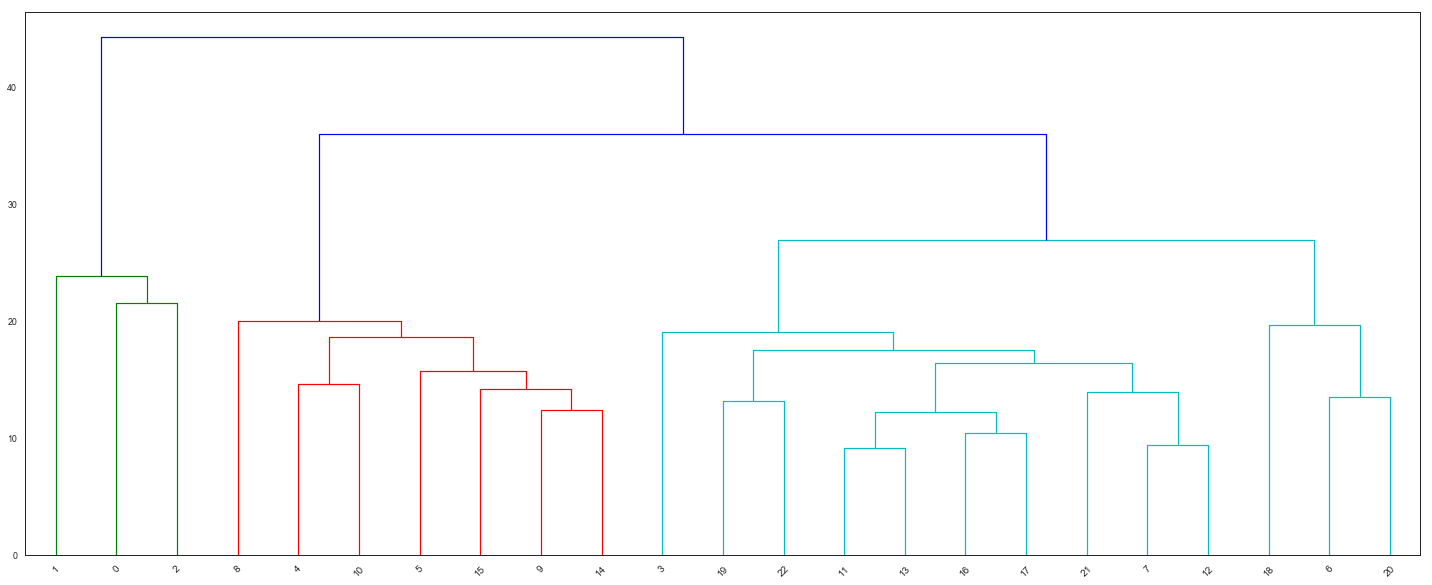

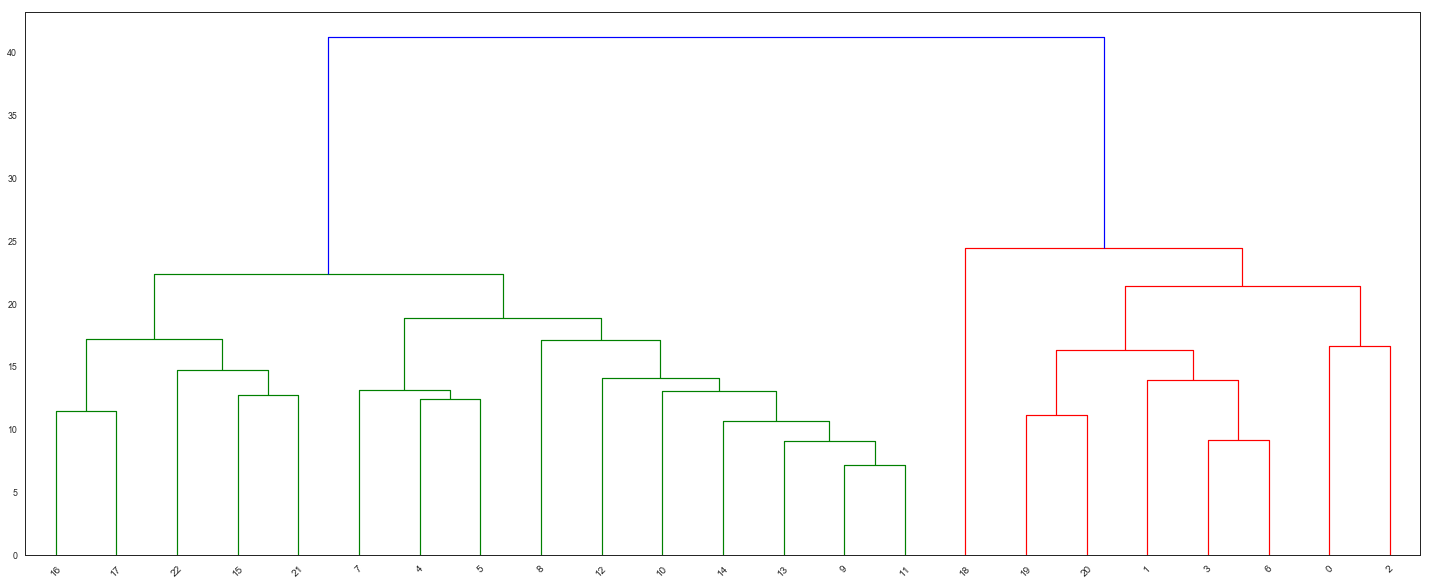

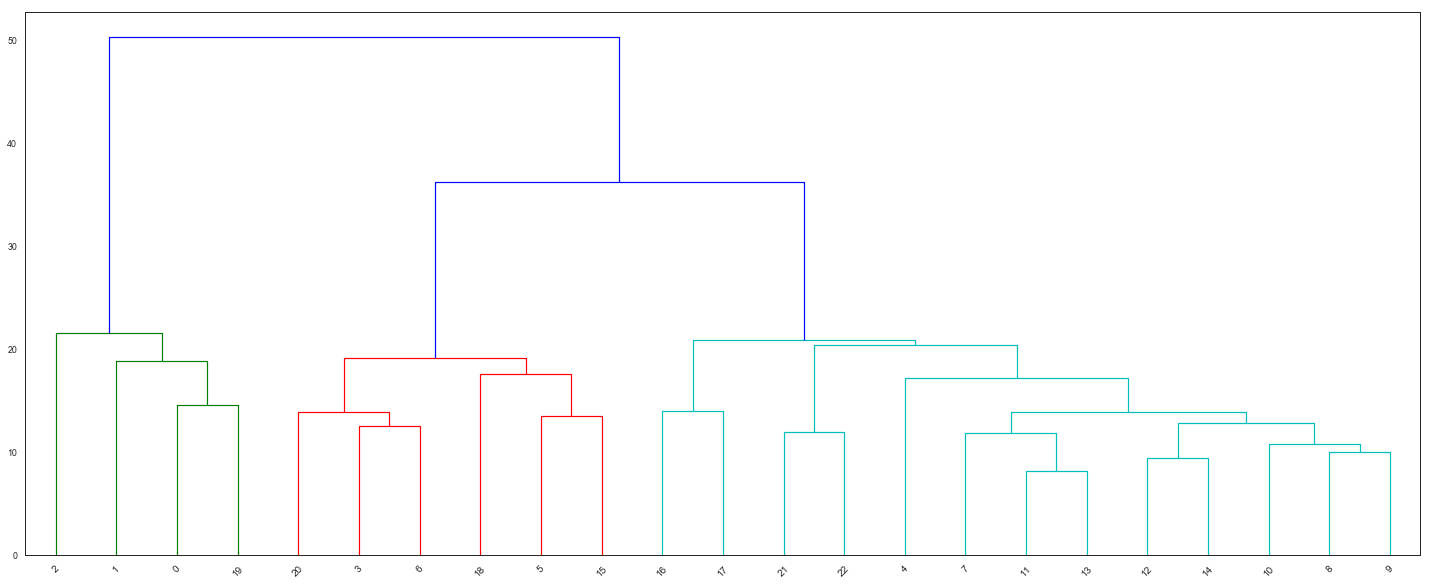

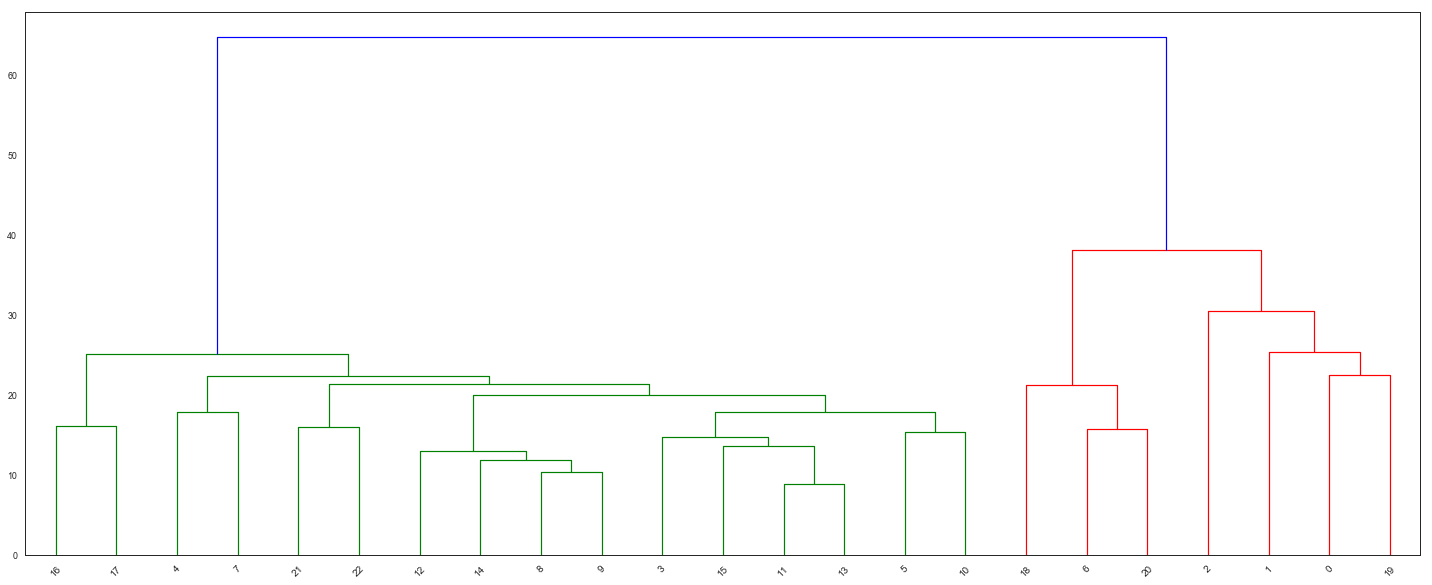

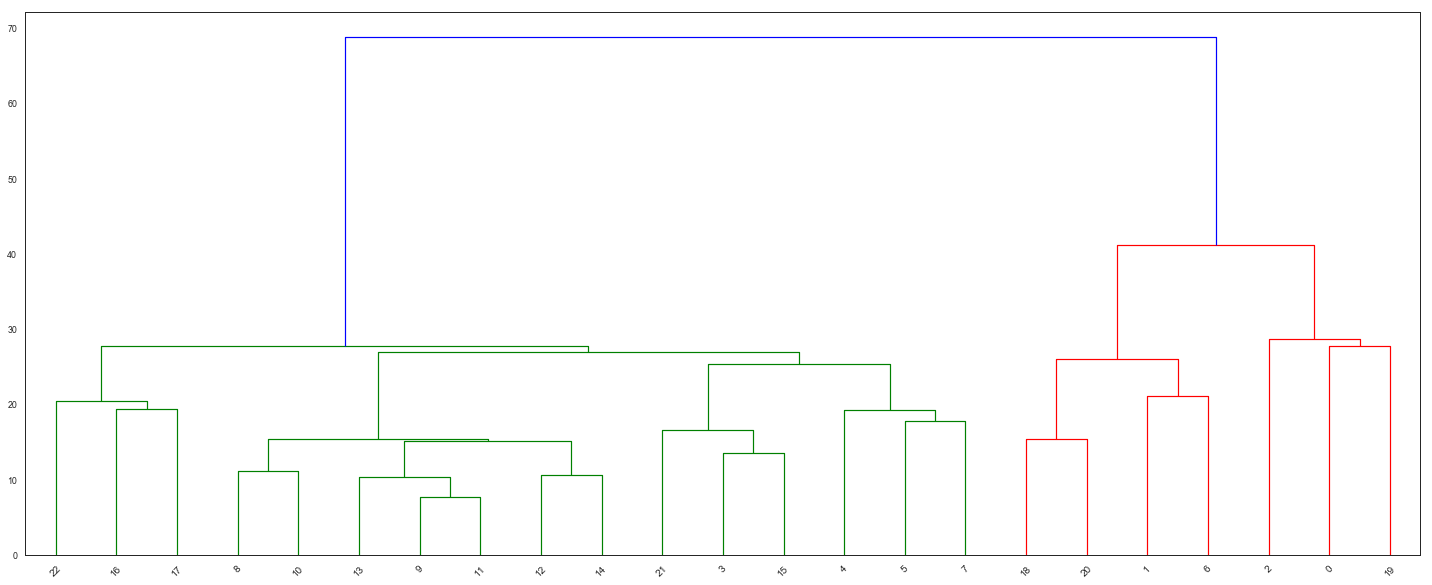

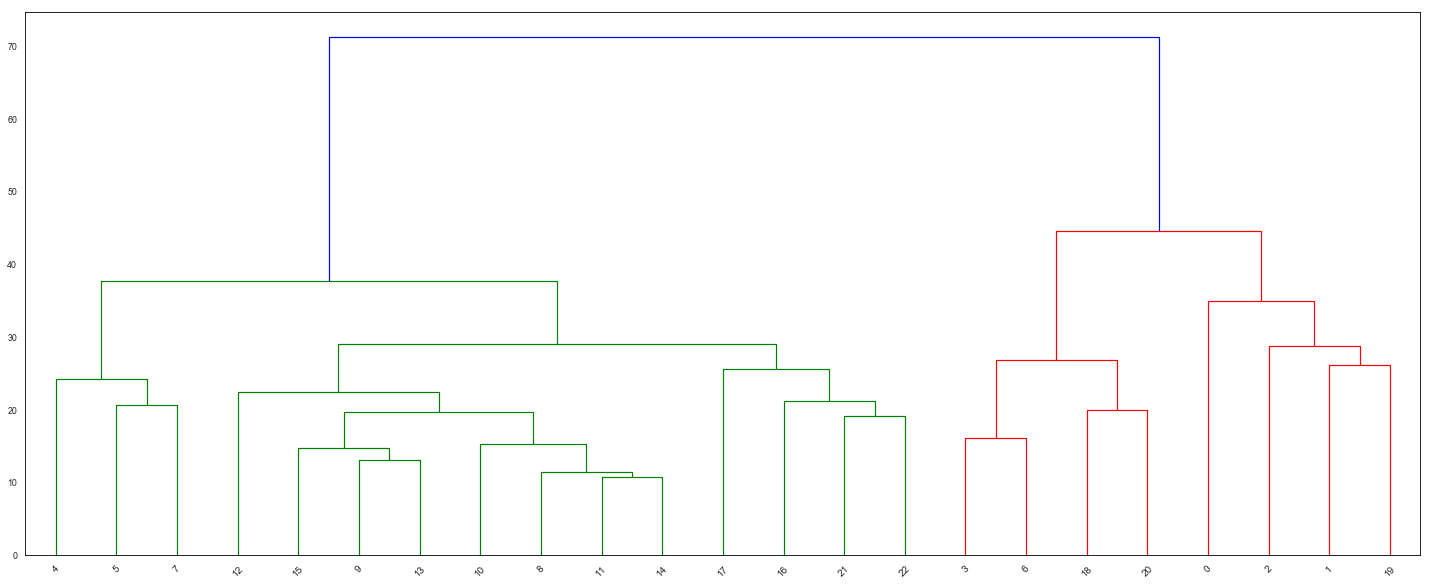

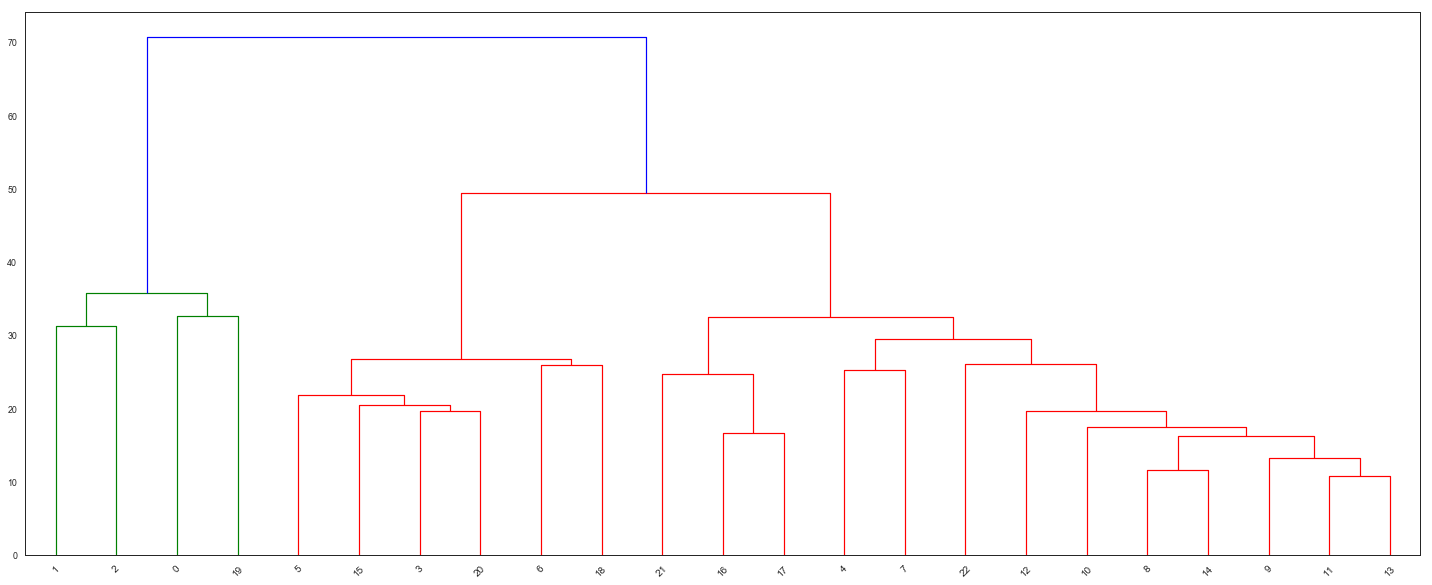

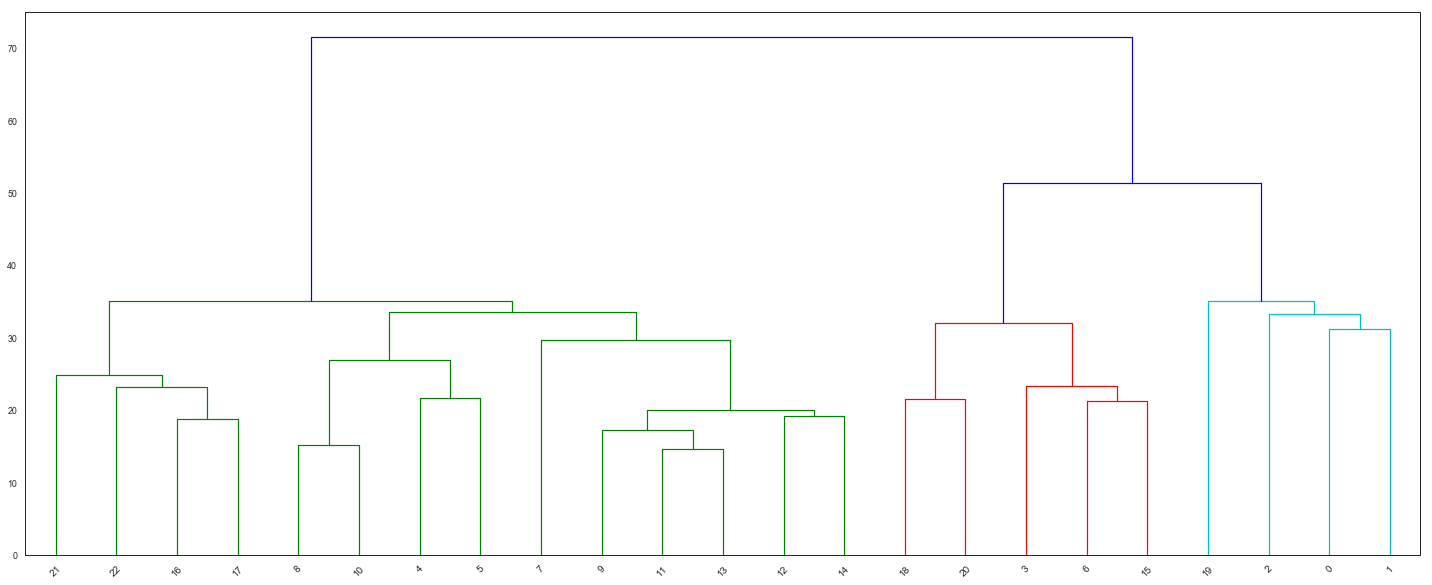

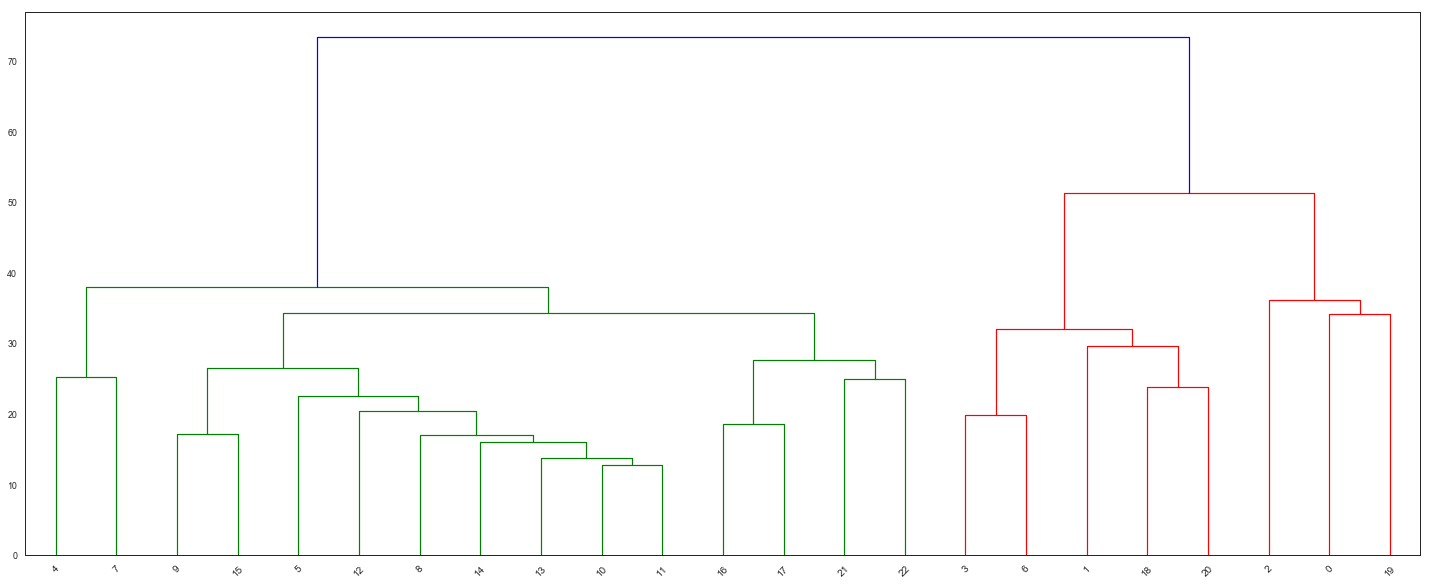

In [37]:
from scipy.cluster.hierarchy import dendrogram, linkage

# for age in (4,6,9):
for age in (2,3,4,5,6,7,8,9,10):
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    
    class_means_age = get_class_means_bl(KF_subset,KM_subset,ordered_objs)
    Z = linkage(class_means_age,'ward')
    plt.figure(figsize=(25, 10))

    dendrogram(Z) 
    plt.show()

In [21]:
# first_class='a person'
# second_class='a cup'
# third_class='a house'
# fig, axs = plt.subplots(3, 3, figsize=(9, 9), sharey=True, sharex=True)

# for agei, age in enumerate(range(2,11)):
#     ## Subset to the age and classes of interest
#     ind = KM.index[KM['age'] == age] & (KM.index[KM.label.values==first_class] | KM.index[KM.label.values==second_class] | KM.index[KM.label.values==third_class])
#     KM_subset =  KM.loc[ind]
#     KF_subset =  KF[ind.tolist()]
    
#     plotColors = np.zeros([np.size(KM_subset.label),3])
#     for i,v in enumerate(np.asarray(KM_subset.label)):
#         if v==first_class:
#             plotColors[i]=[255,0,0]
#         elif v==second_class:
#             plotColors[i]=[0,0,255]
#         elif v==third_class:
#             plotColors[i]=[0,255,0]
    
#     ## Compute distances on this subset
#     subset_distances = pairwise.euclidean_distances(KF_subset)
#     mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
#                        dissimilarity="precomputed", n_jobs=1)
#     pos = mds.fit(subset_distances).embedding_
#     s = 10 ## size of the dots
#     ## sublot indexes, messy but OK for now
#     if agei<3: ## 0,1,2
#         plot_row=0
#         plot_col=agei
#     elif (agei>2) and (agei<6):
#         plot_row=1
#         plot_col=agei-3  
#     elif agei>5: # 6,7,8
#         plot_row=2
#         plot_col=agei-6
#     else:
#         error('badly specified plots')
    
#     axs[plot_row,plot_col].scatter(pos[:, 0], pos[:, 1], c=plotColors/255.0, s=s, lw=0, label='MDS')
# #     axs[agei].title('age' + str(age) + " " + first_class + " vs. "+ second_class)
#     axs[plot_row,plot_col].set_xlim([-200,200])
#     axs[plot_row,plot_col].set_ylim([-200,200])
#     axs[plot_row,plot_col].set_title('age' + str(age))
    
# plt.savefig('./plots-MDS/Distance_MDS_{}_{}_{}.pdf'.format(first_class,second_class,third_class), bbox_inches="tight")
